In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

# pv_data = pd.read_csv('pv_proceeded.csv')[55000:70000]
# pv_data = pd.read_csv('pv_proceeded.csv')[70000:85000]
# pv_data = pd.read_csv('pv_proceeded.csv')[55000:85000]
pv_data = pd.read_csv('pv_proceeded.csv')

print(pv_data.shape)
pv_data.head()

(106648, 3)


time  power  generation
0  2020-05-07 15:00:00  1.949         0.2
1  2020-05-07 15:15:00  1.432         0.3
2  2020-05-07 15:30:00  1.368         0.4
3  2020-05-07 15:45:00  1.340         0.3
4  2020-05-07 16:00:00  0.996         0.2

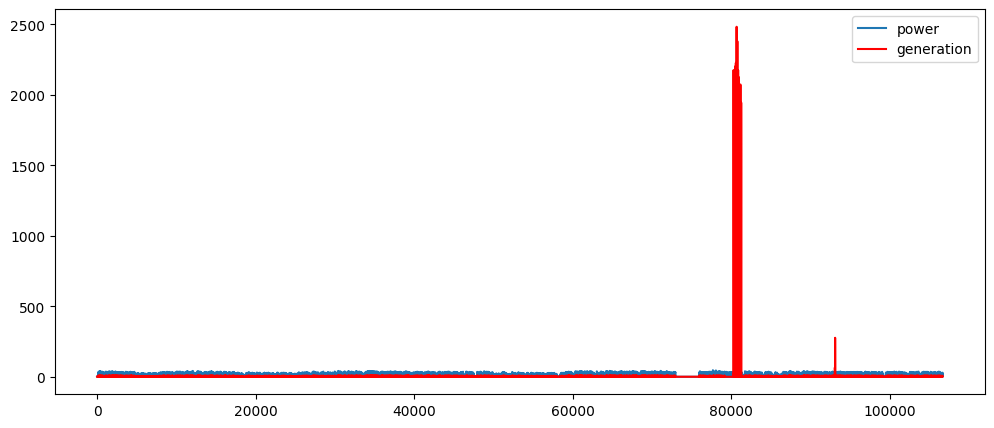

In [2]:
plt.figure(figsize=(12, 5))
plt.plot(range(len(pv_data['power'])), pv_data['power'], label='power')
plt.plot(range(len(pv_data['generation'])), pv_data['generation'], color='red', label='generation')
plt.legend()

In [3]:
def func(x: str):
    x = x[-8:]
    x = x.split(':')
    # print(x)
    t = int(x[0])
    t += float(x[1]) / 60
    return t

pv_data['daytime'] = pv_data['time'].apply(func)
pv_data.head()

time  power  generation  daytime
0  2020-05-07 15:00:00  1.949         0.2    15.00
1  2020-05-07 15:15:00  1.432         0.3    15.25
2  2020-05-07 15:30:00  1.368         0.4    15.50
3  2020-05-07 15:45:00  1.340         0.3    15.75
4  2020-05-07 16:00:00  0.996         0.2    16.00

<Axes: >

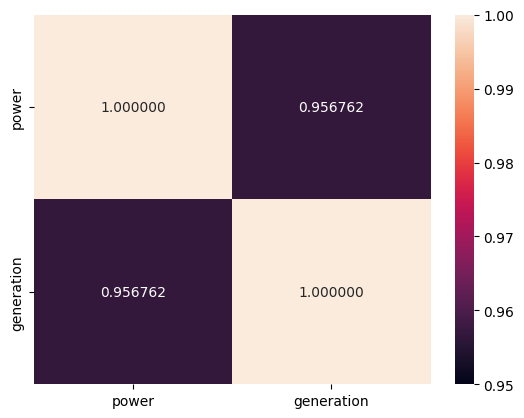

In [4]:
corr_matrix = pv_data[['power','generation']].corr('spearman')
import seaborn as sns
sns.heatmap(corr_matrix, annot=True, fmt='.6f', vmin=0.95)

In [5]:
data = pv_data[['power','generation']][:60000]
from sklearn.preprocessing import StandardScaler
power_scaler = StandardScaler()
generation_scaler = StandardScaler()
data['power'] = power_scaler.fit_transform(data['power'].to_numpy().reshape(-1, 1))
data['generation'] = generation_scaler.fit_transform(data['generation'].to_numpy().reshape(-1, 1))

from sklearn.linear_model import LinearRegression

lr = LinearRegression()
X = data[['power']]
y = data['generation']
lr.fit(X=X, y=y)
y_pred = lr.predict(X)

from sklearn.metrics import mean_absolute_error, mean_squared_error
y_pred = generation_scaler.inverse_transform(y_pred.reshape(-1, 1))
y = generation_scaler.inverse_transform(y.to_numpy().reshape(-1, 1))
print(mean_squared_error(y_pred, y))
print(mean_absolute_error(y_pred, y))


0.02273548027575829
0.03774908462954722


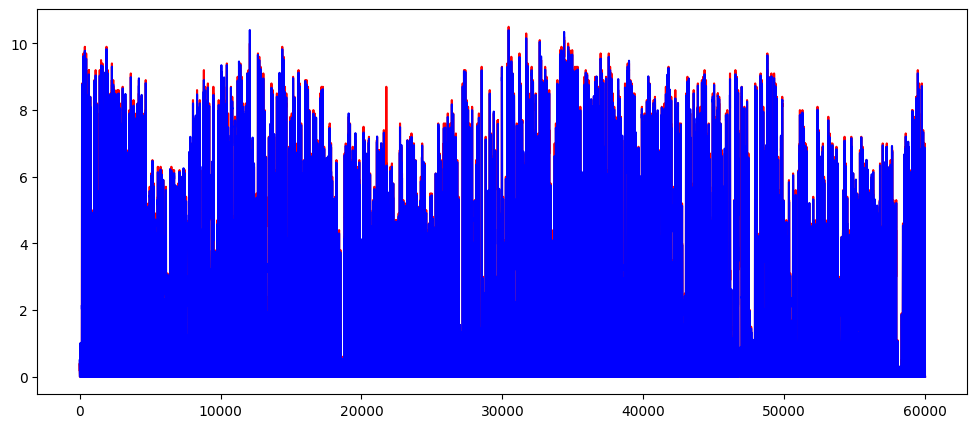

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(range(len(y_pred)), y, color='red')
plt.plot(range(len(y_pred)), y_pred, color='blue')

In [35]:
x = power_scaler.transform(pv_data['power'].to_numpy().reshape(-1, 1))
x = pd.DataFrame(x, columns=['power'])
x = lr.predict(x)
pv_data['generation_pred'] = generation_scaler.inverse_transform(x.reshape(-1, 1))
pv_data['sub'] = np.abs(pv_data['generation_pred'] - pv_data['generation']) ** 2
pv_data.head()

time  power  generation  daytime  generation_pred       sub  \
0  2020-05-07 15:00:00  1.949         0.2    15.00         0.488349  0.083145   
1  2020-05-07 15:15:00  1.432         0.3    15.25         0.358530  0.003426   
2  2020-05-07 15:30:00  1.368         0.4    15.50         0.342460  0.003311   
3  2020-05-07 15:45:00  1.340         0.3    15.75         0.335429  0.001255   
4  2020-05-07 16:00:00  0.996         0.2    16.00         0.249050  0.002406   

   abnormal  color  
0         0  green  
1         1   blue  
2         1   blue  
3         1   blue  
4         1   blue

In [39]:
pv_data['abnormal'] = pv_data['sub'].apply(lambda x: 0 if x >= 0.0227 else 1)
print(pv_data['abnormal'].value_counts())
pv_data.head()

1    100315
0      6333
Name: abnormal, dtype: int64


time  power  generation  daytime  generation_pred       sub  \
0  2020-05-07 15:00:00  1.949         0.2    15.00         0.488349  0.083145   
1  2020-05-07 15:15:00  1.432         0.3    15.25         0.358530  0.003426   
2  2020-05-07 15:30:00  1.368         0.4    15.50         0.342460  0.003311   
3  2020-05-07 15:45:00  1.340         0.3    15.75         0.335429  0.001255   
4  2020-05-07 16:00:00  0.996         0.2    16.00         0.249050  0.002406   

   abnormal color  
0         0  blue  
1         1  blue  
2         1  blue  
3         1  blue  
4         1  blue

time  power  generation  daytime  generation_pred       sub  \
0  2020-05-07 15:00:00  1.949         0.2    15.00         0.488349  0.083145   
1  2020-05-07 15:15:00  1.432         0.3    15.25         0.358530  0.003426   
2  2020-05-07 15:30:00  1.368         0.4    15.50         0.342460  0.003311   
3  2020-05-07 15:45:00  1.340         0.3    15.75         0.335429  0.001255   
4  2020-05-07 16:00:00  0.996         0.2    16.00         0.249050  0.002406   

   abnormal  color  
0         0  green  
1         1   blue  
2         1   blue  
3         1   blue  
4         1   blue

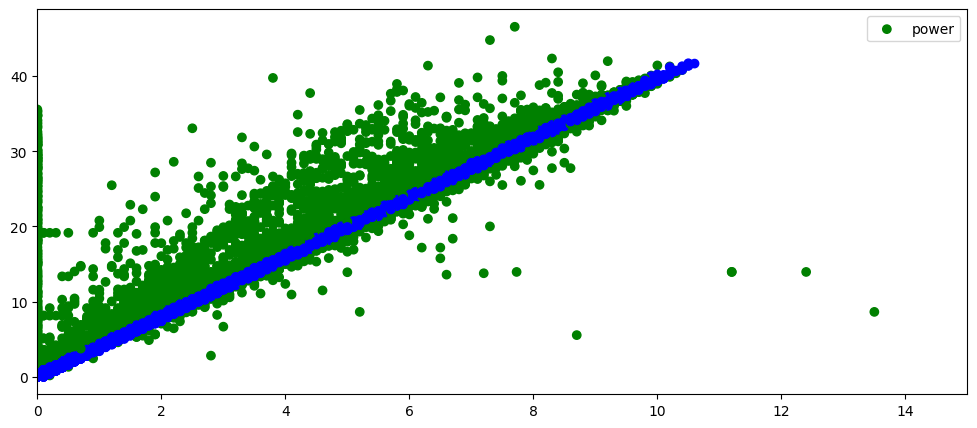

In [40]:
plt.figure(figsize=(12, 5))
pv_data['color'] = pv_data['abnormal'].apply(lambda x: 'green' if x == 0 else 'blue')
plt.scatter(pv_data['generation'], pv_data['power'], c=pv_data['color'])
plt.legend()
plt.xlim(0, 15)